# Projet 1 - Valeurs de SHAPLEY

Elyes KHALFALLAH & Edouard CHAPPON

MALIA

---

---


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from xgboost import XGBClassifier
import shap


c:\Users\elyes\Desktop\MALIA\XAI_Project\env_xai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
path_features = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)

columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

df = pd.read_csv(path_features, names=columns, na_values=" ?")


In [3]:
def preprocess_data(df):
    df.drop(columns=["fnlwgt", "education"], inplace=True)  # Remove redundant columns
    df.dropna(inplace=True)  # Remove missing values
    df["income"] = df["income"].apply(
        lambda x: 1 if x.strip() == ">50K" else 0
    )  # Encode target
    df = pd.get_dummies(
        df, drop_first=True
    )  # One-hot encoding for categorical features
    return df


df = preprocess_data(df)


In [4]:
# Split features and target
x = df.drop(columns=["income"])
y = df["income"]


<Axes: ylabel='income'>

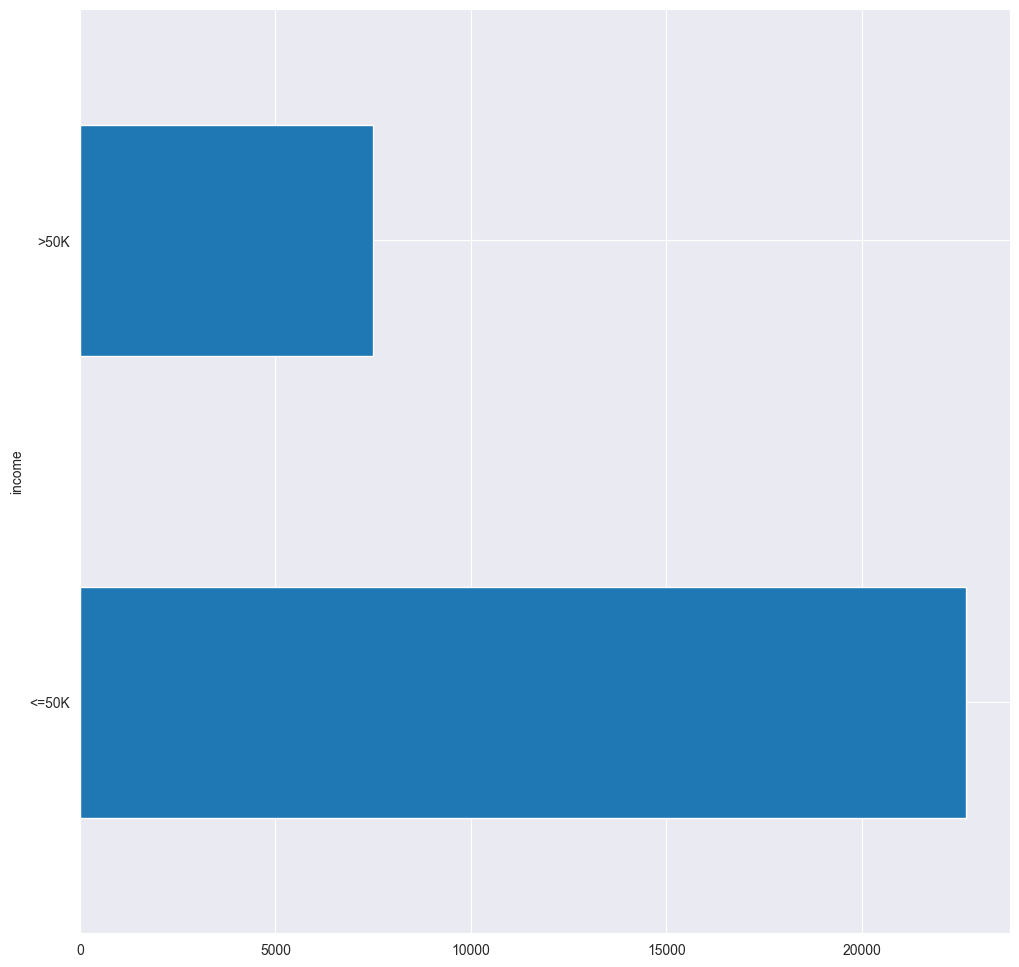

In [5]:
# Show distribution of values
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 12))
counter = y.value_counts()
counter.rename(index={1.0: ">50K", 0.0: "<=50K"}, inplace=True)
ax.set_xlabel("# Cases", size=16)
counter.plot(kind="barh", ax=ax)


In [6]:
# Train/test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.3, random_state=80, stratify=y
)


In [7]:
# Get class proportions
proportion_class = y_train.value_counts()[0] / y_train.value_counts()[1]


In [8]:
# XGBoost parameters
params_xgb = {
    "n_estimators": 200,
    "max_depth": 8,
    "learning_rate": 0.05,
    "scale_pos_weight": proportion_class,
}


In [9]:
# Train model
xgb = XGBClassifier(**params_xgb, use_label_encoder=False, eval_metric="logloss")
xgb.fit(x_train, y_train)


c:\Users\elyes\Desktop\MALIA\XAI_Project\env_xai\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [10]:
# Generate predictions
y_hat = xgb.predict(x_test)
cf = metrics.confusion_matrix(y_test, y_hat)
cf_df = pd.DataFrame(cf, index=["<=50K", ">50K"], columns=["<=50K", ">50K"])


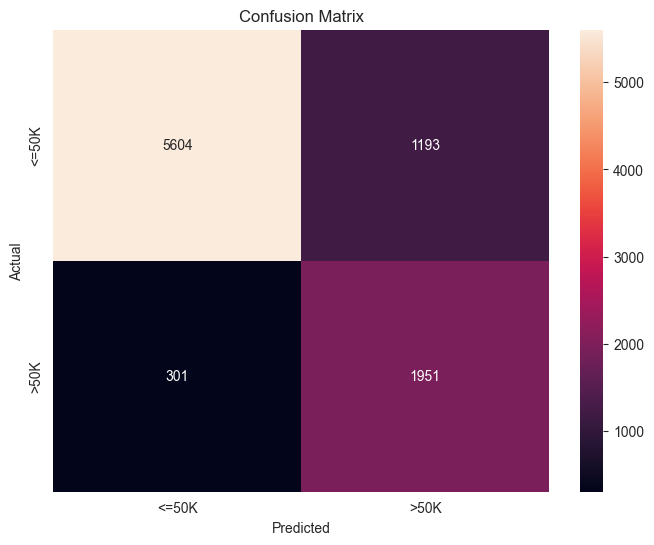

In [11]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_df, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
# SHAP explanation
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_test)


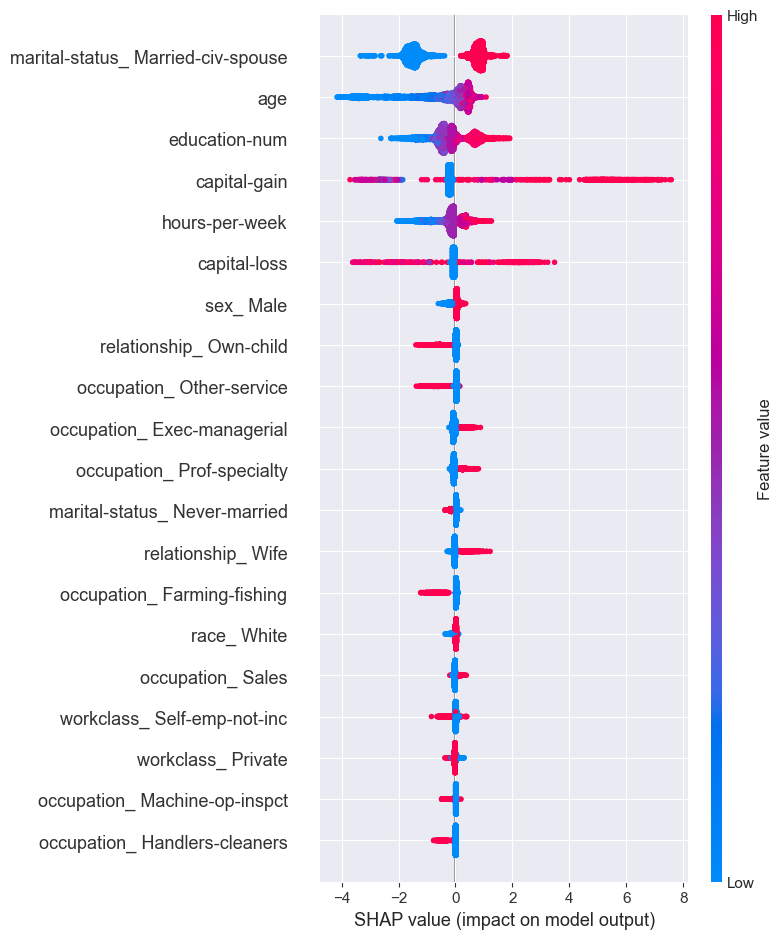

In [13]:
shap.summary_plot(shap_values, x_test)


In [14]:
# Person real target value

for person_index in range(10):
    status_map = {1.0: ">50K", 0.0: "<=50K"}

    pred_class = xgb.predict(x.loc[person_index:person_index, :])[0]
    if pred_class == 0.0:
        pred_diagnosis = status_map[0.0]
        p1 = xgb.predict_proba(x.loc[person_index:person_index, :])[0][0]
        p1_round = round(p1, 3)
    else:
        pred_diagnosis = status_map[1.0]
        p1 = xgb.predict_proba(x.loc[person_index:person_index, :])[0][1]
        p1_round = round(p1, 3)

    print(
        f"Personne n.{person_index:2}:\tReal : {y.replace(status_map).iloc[person_index]:>6}\n\t\tProb of {pred_diagnosis:>5} : {p1_round:,.3f}\n"
    )


Personne n. 0:	Real :  <=50K
		Prob of <=50K : 0.982

Personne n. 1:	Real :  <=50K
		Prob of  >50K : 0.538

Personne n. 2:	Real :  <=50K
		Prob of <=50K : 0.941

Personne n. 3:	Real :  <=50K
		Prob of <=50K : 0.746

Personne n. 4:	Real :  <=50K
		Prob of  >50K : 0.528

Personne n. 5:	Real :  <=50K
		Prob of  >50K : 0.930

Personne n. 6:	Real :  <=50K
		Prob of <=50K : 0.996

Personne n. 7:	Real :   >50K
		Prob of  >50K : 0.689

Personne n. 8:	Real :   >50K
		Prob of  >50K : 0.998

Personne n. 9:	Real :   >50K
		Prob of  >50K : 0.995



In [15]:
shap.initjs()

person_index = 5

shap.force_plot(
    explainer.expected_value, shap_values[person_index, :], x.iloc[person_index, :]
)
